# Case Study

In [1]:
import pandas as pd
import numpy as np
import urllib.request
from io import StringIO
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from scipy.optimize import minimize
import statistics
import calendar
import scipy.stats as stats
import matplotlib.dates as mdates
from scipy.stats import norm

import warnings
np.seterr(divide='ignore', invalid='ignore')
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", message="An unsupported index was provided and will be ignored when e.g. forecasting.")

In [2]:
def import_data(link):
  """ Imports the data from a certain url link

    Args:
        link (str): url to the data

    """
  with urllib.request.urlopen(link) as response:
      data = response.read().decode('utf-8')

  data = data.split("\n")
  data_list = []

  for row in data[2:-1]:
      row_list = list(filter(None, row.split(' ')))
      row_list[1] = row_list[1].rstrip('\r')
      data_list.append({'Date': row_list[0], 'Value': row_list[1]})

  df = pd.DataFrame(data_list)
  df['Date'] = pd.to_datetime(df['Date'])
  df['Value'] = df['Value'].astype(float)
  return df

In [3]:
def delete_leap_year(df):
  """ Deletes leap years from the data frame

    Args:
        df (pd.DataFrame): data frame with leap years

    Returns:
        pd.DataFrame: df without the day 02-29

    """
  df['Day'] = df['Date'].dt.day
  df['Month'] = df['Date'].dt.month
  df = df[~((df['Month'] == 2) & (df['Day'] == 29))]
  df.drop(columns=['Day', 'Month'], inplace=True)
  df.reset_index(drop=True, inplace=True)
  return df

In [4]:
def fill_matrix(df, year, day, w):
    """ Fill the matrix with ones for a specic day in a year given a certain window

    Args:
        df (pd.DataFrame): contains the matrix with zeros and ones
        year (int): the year for for which we want to fill the days with ones
        day (str): the day around we want to fill the days with ones
        w (int): the window indicates how many days we want to fill with ones
    """

    day_ind = df.columns.get_loc(day)

    # Loop throught the window
    for i in range(0, int(w/2)):
        ind_bef = day_ind - i
        ind_aft = day_ind + i

        # Handle if days exceeds year
        if ind_aft >= len(df.columns):
            year_aft = year + 1
            df.loc[year_aft, df.columns[ind_aft - len(df.columns)]] = 1
        # Set to 1 for days in given year
        elif ind_aft < len(df.columns):
          df.loc[year, df.columns[ind_aft]] = 1


        # Handle if days deceeds year
        if ind_bef < 0:
            year_bef = year - 1
            df.loc[year_bef, df.columns[ind_bef + len(df.columns)]] = 1
        # Set to 1 for days in given year
        elif ind_bef >= 0:
          df.loc[year, df.columns[ind_bef]] = 1


In [5]:
def get_matrix(first_year, last_year, day):
    """ Create a matrix containing zeros and ones for a specific block around a
    day within certain years

    Args:
        first_year (str): the first year for which we want to create a window of
        ones
        last_year (str): the last year for which we want to create a window of
        ones
        day (str): the day around we want to fill the days with ones

    Returns:
        pd.DataFrame: df containing zeros and ones for a specific date (note
        that the df contains an extra year before and after the last year)

    """

    # Create a list containing all days of a non-leap year
    days_in_year = pd.date_range(start=f'1/1/{2023}', end=f'12/31/{2023}', freq='D')

    # Make a df with days as columns and years 1979-2021 as rows
    df = pd.DataFrame(0, index=range(first_year-1, last_year+2), columns=[f'{date.day}-{date.month}' for date in days_in_year])

    # Define window
    w = 30

    # Loop through the years and fill matrix with 1 ones around a specific date given a window w
    for year in range(first_year, last_year + 1):
        fill_matrix(df, year, day,w)

    return df

In [6]:
def get_h_min1(h):
    shifted_h = np.roll(h, 1)
    
    days_in_year = pd.date_range(start=f'1/1/{2023}', end=f'12/31/{2023}', freq='D')
    
    h_min1 = pd.DataFrame(shifted_h, columns=[f'{date.day}-{date.month}' for date in days_in_year])

    return h_min1

In [7]:
def get_subset_df(df, first_year, last_year):
    """ Create a subset of a dataframe given certain years

    Args:
        first_year (str): the first year included in the subset
        last_year (str): the last year included in the subset
        df (pd.DataFrame): df from which we want the subset

    Returns:
        pd.DataFrame: df containing the subset

    """

    subset = df[(df['Date'] >= str(first_year)) & (df['Date'] < str(last_year+1))]

    chunk_size = 365
    chunks = [subset[i:i+chunk_size] for i in range(0, len(subset), chunk_size)]

    df_subset = pd.DataFrame()

    for year in range(0,(last_year-first_year+1)):
        value_series = chunks[year]['Value'].reset_index(drop=True)
        columns = []

        for day in range(0, 365):
            value_for_day = value_series[day]
            column_series = pd.Series(value_for_day)
            columns.append(column_series)

        df_1_year = pd.concat(columns, axis=1)
        df_subset = pd.concat([df_subset, df_1_year], ignore_index=True)

    days_in_year = pd.date_range(start=f'1/1/{2023}', end=f'12/31/{2023}', freq='D')
    df_subset.columns = [f'{date.day}-{date.month}' for date in days_in_year]
    df_subset.index = range(first_year, last_year+1)
    return df_subset

In [8]:
df = import_data('https://hadleyserver.metoffice.gov.uk/hadcet/data/meantemp_daily_totals.txt')

In [9]:
df = delete_leap_year(df)
for i in df['Date']:
    if '-02-29' in str(i):
        print(i)

## AR model

In [10]:
def estimate_AR_params(df, first_year, last_year):
    """ Calculate the phi for every day over a certain time period
    
    Args:
        first_year (str): the first year of the time period
        last_year (str): the last year of the time period
        df (pd.DataFrame): df containing the temperature
    
    Returns:
        list: phi_list contains the phi's for every day in the time period
        list: ci_upper_list contains the upper CI for the phi's
        list: ci_lower_list contains the lower CI for the phi's
    
    """
    df_subset = get_subset_df(df, first_year-1, last_year+1)
    
    phi_list = []
    phi_ci_upper_list = []
    phi_ci_lower_list = []

    alpha_list = []
    alpha_ci_upper_list = []
    alpha_ci_lower_list = []

    mu_list = []
    
    for date in pd.date_range(start='1/1/2023', end='12/31/2023', freq='D'):
        print(f'Currently estimating: {calendar.month_name[date.month]} {date.day}' + " " * 15, end='\r')
        
        # Obtain variables
        h = get_matrix(first_year, last_year, f'{date.day}-{date.month}')
        y = df_subset.values * h.values
        y_bar = sum(y) / sum(h.values)
        y_tilde = (y - y_bar*h).fillna(0)
        
        h_min1 = get_h_min1(h)
        y_min1 = np.roll(y, 1)
        y_bar_min1 = sum(y_min1) / sum(h_min1.values)
        y_tilde_min1 = (y_min1 - y_bar_min1*h_min1).fillna(0)

        # Compute phi
        phi_hat = (y_tilde.values*y_tilde_min1.values).sum() / (y_tilde_min1.values**2*h.values*h_min1.values).sum()
        phi_ci_upper = phi_hat + np.sqrt((1-phi_hat**2)/(h.values*h_min1.values).sum())*norm.ppf(1 - 0.05 / 2)
        phi_ci_lower = phi_hat - np.sqrt((1-phi_hat**2)/(h.values*h_min1.values).sum())*norm.ppf(1 - 0.05 / 2)

        # Compute alpha
        alpha_hat = (h.values*h_min1.values*(y-phi_hat*y_min1)).sum() / (h.values*h_min1.values).sum()
        alpha_ci_upper = alpha_hat + np.sqrt((((y**2).sum()/h.values.sum())*(1-phi_hat**2))/(h.values*h_min1.values).sum())*norm.ppf(1 - 0.05 / 2)
        alpha_ci_lower = alpha_hat - np.sqrt((((y**2).sum()/h.values.sum())*(1-phi_hat**2))/(h.values*h_min1.values).sum())*norm.ppf(1 - 0.05 / 2)

        # Compute mu
        mu_hat = alpha_hat / (1 - phi_hat)

        # Append the results
        phi_list.append(phi_hat)
        phi_ci_upper_list.append(phi_ci_upper)
        phi_ci_lower_list.append(phi_ci_lower)
        
        alpha_list.append(alpha_hat)
        alpha_ci_upper_list.append(alpha_ci_upper)
        alpha_ci_lower_list.append(alpha_ci_lower)

        mu_list.append(mu_hat)

    # Append to dataframe
    AR_df = pd.DataFrame()
    AR_df['Date'] = pd.date_range(start='1/1/2023', end='12/31/2023', freq='D')
    AR_df['Phi'] = phi_list
    AR_df['Phi upper bound'] = phi_ci_upper_list
    AR_df['Phi lower bound'] = phi_ci_lower_list
    AR_df['Alpha'] = alpha_list
    AR_df['Alpha upper bound'] = alpha_ci_upper_list
    AR_df['Alpha lower bound'] = alpha_ci_lower_list
    AR_df['Mu'] = mu_list

    print('Finished estimating AR parameters!'+ " " * 15, end='\r')
    
    return AR_df

In [11]:
AR_df = estimate_AR_params(df, 1980, 2020)
AR_df

,Date,Phi,Phi upper bound,Phi lower bound,Alpha,Alpha upper bound,Alpha lower bound,Mu
0,2023-01-01,0.858131,0.887831,0.828431,0.651036,0.822631,0.479442,4.588989
1,2023-01-02,0.857122,0.886919,0.827324,0.667383,0.839653,0.495113,4.670986
2,2023-01-03,0.852634,0.882859,0.822409,0.683865,0.858062,0.509668,4.640592
3,2023-01-04,0.849060,0.879620,0.818499,0.670207,0.845635,0.494779,4.440207
4,2023-01-05,0.850126,0.880587,0.819666,0.663939,0.838032,0.489846,4.429992
...,...,...,...,...,...,...,...,...
360,2023-12-27,0.848130,0.878776,0.817483,0.711427,0.888390,0.534464,4.684438
361,2023-12-28,0.852148,0.882419,0.821877,0.695374,0.870199,0.520548,4.703167
362,2023-12-29,0.857646,0.887393,0.827898,0.659942,0.832063,0.487821,4.635906
363,2023-12-30,0.859019,0.888634,0.829405,0.652789,0.824413,0.481165,4.630347


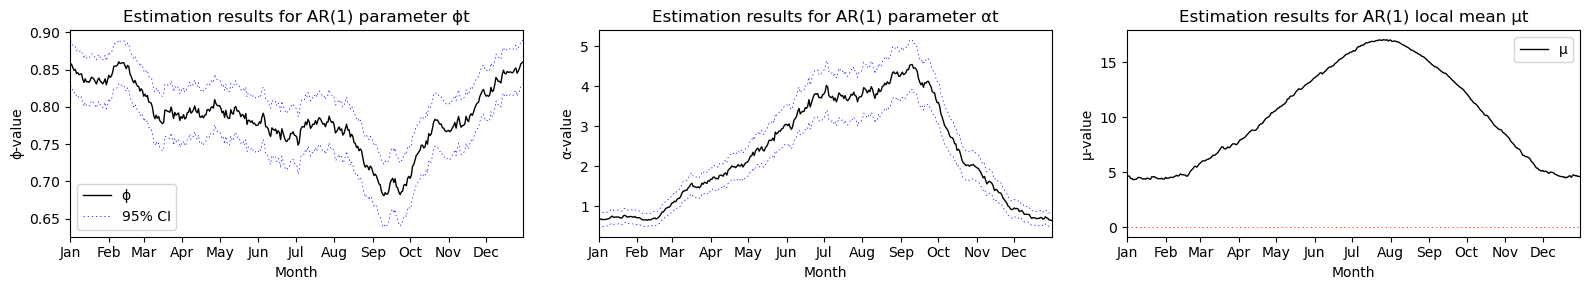

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 3))

ax1.plot(AR_df['Date'], AR_df['Phi'], label='ϕ', linestyle='-', color='black', linewidth=1)
ax1.plot(AR_df['Date'], AR_df['Phi upper bound'], linestyle='--', label='95% CI', color='blue', linewidth=0.5, dashes=(2, 4))
ax1.plot(AR_df['Date'], AR_df['Phi lower bound'], linestyle='--', color='blue', linewidth=0.5, dashes=(2, 4))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.set_xlim(AR_df['Date'].min(), AR_df['Date'].max())
ax1.set_title('Estimation results for AR(1) parameter ϕt')
ax1.set_xlabel('Month')
ax1.set_ylabel('ϕ-value')
ax1.legend()

ax2.plot(AR_df['Date'], AR_df['Alpha'], label='α', linestyle='-', color='black', linewidth=1)
ax2.plot(AR_df['Date'], AR_df['Alpha upper bound'], linestyle='--', label='95% CI', color='blue', linewidth=0.5, dashes=(2, 4))
ax2.plot(AR_df['Date'], AR_df['Alpha lower bound'], linestyle='--', color='blue', linewidth=0.5, dashes=(2, 4))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax2.xaxis.set_major_locator(mdates.MonthLocator())
ax2.set_xlim(AR_df['Date'].min(), AR_df['Date'].max())
ax2.set_title('Estimation results for AR(1) parameter αt')
ax2.set_xlabel('Month')
ax2.set_ylabel('α-value')
ax2.legend

ax3.plot(AR_df['Date'], AR_df['Mu'], label='µ', linestyle='-', color='black', linewidth=1)
ax3.axhline(0, color='red', linestyle='--', linewidth=0.5, dashes=(2, 4))
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax3.xaxis.set_major_locator(mdates.MonthLocator())
ax3.set_xlim(AR_df['Date'].min(), AR_df['Date'].max())
ax3.set_title('Estimation results for AR(1) local mean µt')
ax3.set_xlabel('Month')
ax3.set_ylabel('µ-value')
ax3.legend()

plt.tight_layout()
plt.show()

## QAR model

In [13]:
def compute_QAR_residuals(params, df, h):
    """ Calculate the residual of a periodic quantile autoregression model
    
    Args:
        params (list): phi and alpha
        df (pd.DataFrame): df containing the temperature
        h (pd.DataFrame): h-matrix of a date
    
    Returns:
        int: residuals of the model with certain params
    
    """
    alpha = params[0]
    phi = params[1]
    q = 0.50
    
    y = df.values
    y_min1 = np.roll(y, 1)
    
    I = np.where(h * (y - alpha - phi * y_min1) < 0, 1, 0)

    residuals = h * (y - alpha - phi * y_min1) * (q - I)

    return residuals.sum().sum()

In [14]:
def estimate_QAR_params(df, first_year, last_year):
    """ Calculate the phi and alpha for every day over a certain time period
    
    Args:
        first_year (str): the first year of the time period
        last_year (str): the last year of the time period
        df (pd.DataFrame): df containing the temperature
    
    Returns:
        list: phi_list contains the phi's for every day in the time period
        list: alpha_list contains the alpha's for every day in the time period
    
    """
    df_subset = get_subset_df(df, first_year-1, last_year+1)

    alpha_list = []
    phi_list = []
    
    for date in pd.date_range(start='1/1/2023', end='12/31/2023', freq='D'):
        print(f'Currently estimating: {calendar.month_name[date.month]} {date.day}' + " " * 15, end='\r')
        
        h = get_matrix(first_year, last_year, f'{date.day}-{date.month}')
        
        result = minimize(compute_QAR_residuals, [3, 0.2], method = 'SLSQP', args=(df_subset, h))
        
        alpha_list.append(result.x[0])
        phi_list.append(result.x[1])
        
    # Append to dataframe
    QAR_df = pd.DataFrame()
    QAR_df['Date'] = pd.date_range(start='1/1/2023', end='12/31/2023', freq='D')
    QAR_df['Phi'] = phi_list
    QAR_df['Alpha'] = alpha_list

    print('Finished estimating QAR parameters!'+ " " * 15, end='\r')
    
    return QAR_df

In [15]:
QAR_df = estimate_QAR_params(df, 1980, 2020)
QAR_df

,Date,Phi,Alpha
0,2023-01-01,0.890625,0.681258
1,2023-01-02,0.891262,0.704272
2,2023-01-03,0.884206,0.709489
3,2023-01-04,0.880944,0.709599
4,2023-01-05,0.873240,0.743660
...,...,...,...
360,2023-12-27,0.880000,0.748000
361,2023-12-28,0.885714,0.717143
362,2023-12-29,0.890631,0.720260
363,2023-12-30,0.898906,0.679518


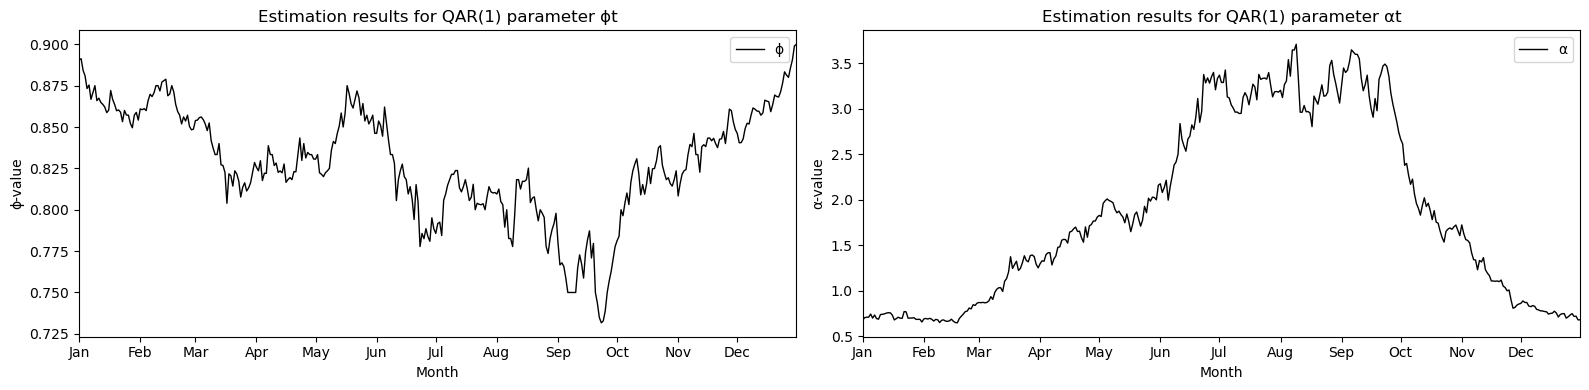

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(QAR_df['Date'], QAR_df['Phi'], label='ϕ', linestyle='-', color='black', linewidth=1)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.set_xlim(QAR_df['Date'].min(), QAR_df['Date'].max())
ax1.set_title('Estimation results for QAR(1) parameter ϕt')
ax1.set_xlabel('Month')
ax1.set_ylabel('ϕ-value')
ax1.legend()

ax2.plot(QAR_df['Date'], QAR_df['Alpha'], label='α', linestyle='-', color='black', linewidth=1)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax2.xaxis.set_major_locator(mdates.MonthLocator())
ax2.set_xlim(QAR_df['Date'].min(), QAR_df['Date'].max())
ax2.set_title('Estimation results for QAR(1) parameter αt')
ax2.set_xlabel('Month')
ax2.set_ylabel('α-value')
ax2.legend()

plt.tight_layout()
plt.show()